In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/6888/project/tomatoAll.zip /content
!unzip /content/tomatoAll.zip

Streaming output truncated to the last 5000 lines.
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/253ddc99-8132-4710-bb89-eb83ab271abc___Matt.S_CG 0698.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25592188-309d-450c-b45f-fbbdb02b316f___Matt.S_CG 6181.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/2567c820-aa63-490c-8e47-921b85164728___Matt.S_CG 7447.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/256b92d9-41f3-47a4-870f-c0c0f0ac201e___Matt.S_CG 6842.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25b6cc2a-d883-4e3f-9caa-738e5ec35e30___JR_Sept.L.S 8465.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25c45a05-4f45-42ad-b18a-b7f694023a31___Matt.S_CG 0824.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25f7a39f-7fef-4f5d-af4f-cf21934f516a___JR_Sept.L.S 2493.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/261666dc-32fb-43b2-93

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils, initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator



base_path = '/content/tomatoAll/'
expert_path = '/content/tomatoAll/plan-diseases-expert'
village_path = '/content/tomatoAll/plant-village'


BATCH_SIZE = 128
IMG_SIZE = (256, 256)
SEED = 42

In [3]:
train_gen, test_gen = tf.keras.utils.image_dataset_from_directory(
    expert_path,
    validation_split=0.15,
    subset="both",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)


VALIDATION_SPLIT = 0.15

train_gen = train_gen.take(int((1 - VALIDATION_SPLIT) * len(train_gen)))
valid_gen = train_gen.skip(int((1 - VALIDATION_SPLIT) * len(train_gen)))

test2_gen = tf.keras.utils.image_dataset_from_directory(
    village_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# use cache to improve speed
train_gen = train_gen.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_gen = valid_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_gen = test_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test2_gen = test2_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Found 37455 files belonging to 9 classes.
Using 31837 files for training.
Using 5618 files for validation.
Found 12803 files belonging to 9 classes.


In [4]:
from tensorflow.keras.applications import ResNet101, InceptionV3, EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
import time
import matplotlib.pyplot as plt

In [6]:
def create_and_train_model(base_model, train_gen, test_gen, model_filename, freeze_layers=True):

    # Freeze layers
    if freeze_layers:
      for layer in base_model.layers:
          layer.trainable = False

    # GlobalAveragePooling2D layer
    x = GlobalAveragePooling2D()(base_model.output)

    # Modify pre-trained model
    output = Dense(9, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Compile
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model for 50 epochs
    history = model.fit(train_gen, validation_data=valid_gen, epochs=30)

    # Save the model
    model.save(model_filename)

    # Plotting Loss
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Measure inference time
    start_time = time.time()
    _, accuracy = model.evaluate(test_gen)
    end_time = time.time()
    inference_time = end_time - start_time

    # Measure inference time 2
    start_time = time.time()
    _, accuracy2 = model.evaluate(test2_gen)
    end_time = time.time()
    inference_time2 = end_time - start_time

    # Get model size (number of parameters)
    num_params = model.count_params()

    return num_params, inference_time, accuracy, inference_time2, accuracy2


Epoch 1/50
13/13 [==============================] - 96s 1s/step - loss: 0.9484 - accuracy: 0.7319 - val_loss: 149927104.0000 - val_accuracy: 0.1570
Epoch 2/50
13/13 [==============================] - 9s 681ms/step - loss: 0.1219 - accuracy: 0.9586 - val_loss: 11431035904.0000 - val_accuracy: 0.1570
Epoch 3/50
13/13 [==============================] - 9s 681ms/step - loss: 0.0311 - accuracy: 0.9900 - val_loss: 795569536.0000 - val_accuracy: 0.1570
Epoch 4/50
13/13 [==============================] - 9s 681ms/step - loss: 0.0097 - accuracy: 0.9970 - val_loss: 29585024.0000 - val_accuracy: 0.1570
Epoch 5/50
13/13 [==============================] - 9s 680ms/step - loss: 0.0040 - accuracy: 0.9989 - val_loss: 1560879.8750 - val_accuracy: 0.1580
Epoch 6/50
13/13 [==============================] - 9s 681ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 103202.4688 - val_accuracy: 0.2139
Epoch 7/50
13/13 [==============================] - 9s 681ms/step - loss: 0.0019 - accuracy: 0.9994 - val_

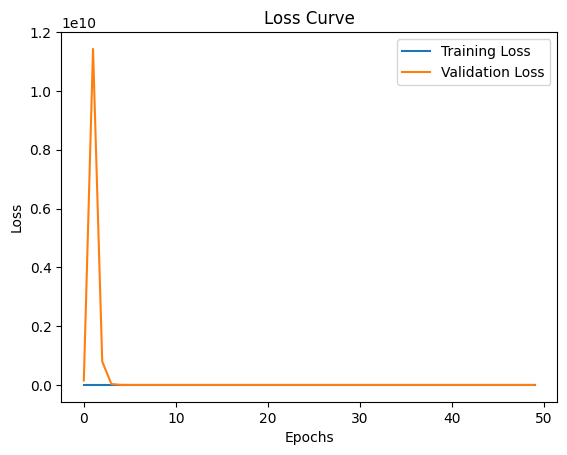

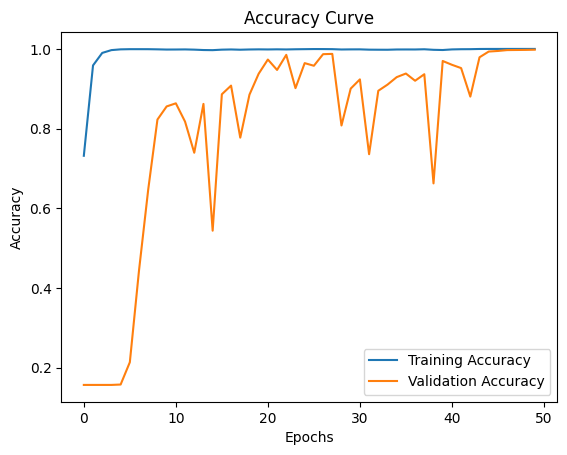

7/7 [==============================] - 3s 299ms/step - loss: 0.0087 - accuracy: 0.9980
ResNet101: Params=42676617, Time=2.354395866394043, Accuracy=0.9914560317993164, Time2=3.2484867572784424, Accuracy2=0.9980473518371582


In [ ]:
# Create and train ResNet101 75 2048
resnet_base = ResNet101(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
resnet_params, resnet_time, resnet_acc, effnet_time2, effnet_acc2 = create_and_train_model(resnet_base, train_gen, test_gen, freeze_layers=False)
print(f"ResNet101: Params={resnet_params}, Time={resnet_time}, Accuracy={resnet_acc}, Time2={effnet_time2}, Accuracy2={effnet_acc2}")

Epoch 1/50
211/211 [==============================] - 161s 446ms/step - loss: 0.2245 - accuracy: 0.9291 - val_loss: 1.3412 - val_accuracy: 0.7122
Epoch 2/50
211/211 [==============================] - 87s 414ms/step - loss: 0.0602 - accuracy: 0.9798 - val_loss: 0.9029 - val_accuracy: 0.8552
Epoch 3/50
211/211 [==============================] - 87s 414ms/step - loss: 0.0364 - accuracy: 0.9879 - val_loss: 1.8712 - val_accuracy: 0.7063
Epoch 4/50
211/211 [==============================] - 87s 414ms/step - loss: 0.0237 - accuracy: 0.9923 - val_loss: 0.5129 - val_accuracy: 0.8733
Epoch 5/50
211/211 [==============================] - 87s 414ms/step - loss: 0.0298 - accuracy: 0.9897 - val_loss: 1.2668 - val_accuracy: 0.7341
Epoch 6/50
211/211 [==============================] - 87s 414ms/step - loss: 0.0159 - accuracy: 0.9944 - val_loss: 0.7163 - val_accuracy: 0.8159
Epoch 7/50
211/211 [==============================] - 87s 414ms/step - loss: 0.0169 - accuracy: 0.9940 - val_loss: 0.1799 - val_a

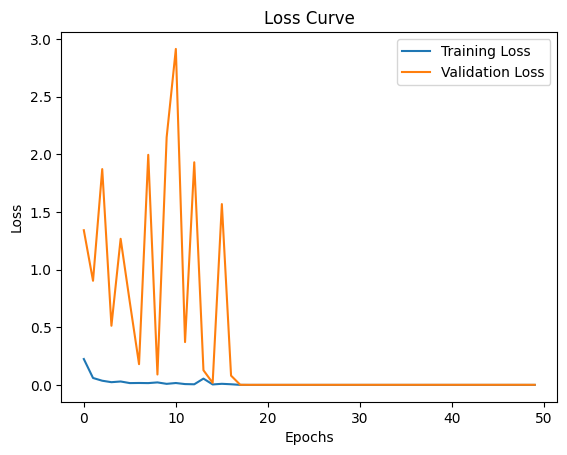

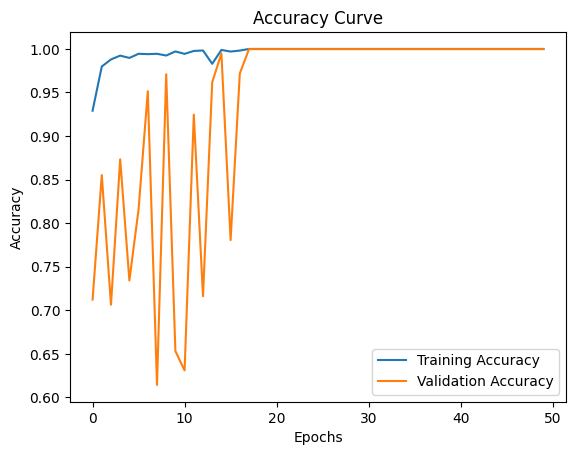

101/101 [==============================] - 17s 163ms/step - loss: 0.0021 - accuracy: 0.9995
ResNet101: Params=42676617, Time=8.344406366348267, Accuracy=0.9989320039749146, Time2=16.652536392211914, Accuracy2=0.9995313882827759


In [ ]:
# Create and train ResNet101 256 128
resnet_base = ResNet101(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
resnet_params, resnet_time, resnet_acc, effnet_time2, effnet_acc2 = create_and_train_model(resnet_base, train_gen, test_gen, freeze_layers=False)
print(f"ResNet101: Params={resnet_params}, Time={resnet_time}, Accuracy={resnet_acc}, Time2={effnet_time2}, Accuracy2={effnet_acc2}")

171446536/171446536 [==============================] - 8s 0us/step
Epoch 1/30
211/211 [==============================] - 170s 445ms/step - loss: 0.2161 - accuracy: 0.9313 - val_loss: 1.5759 - val_accuracy: 0.7175
Epoch 2/30
211/211 [==============================] - 87s 414ms/step - loss: 0.0576 - accuracy: 0.9815 - val_loss: 1.8755 - val_accuracy: 0.6208
Epoch 3/30
211/211 [==============================] - 87s 414ms/step - loss: 0.0239 - accuracy: 0.9924 - val_loss: 0.5507 - val_accuracy: 0.8391
Epoch 4/30
211/211 [==============================] - 87s 414ms/step - loss: 0.0275 - accuracy: 0.9909 - val_loss: 0.6390 - val_accuracy: 0.8882
Epoch 5/30
211/211 [==============================] - 87s 414ms/step - loss: 0.0233 - accuracy: 0.9918 - val_loss: 5.1154 - val_accuracy: 0.4050
Epoch 6/30
211/211 [==============================] - 87s 414ms/step - loss: 0.0339 - accuracy: 0.9889 - val_loss: 16.4585 - val_accuracy: 0.2744
Epoch 7/30
211/211 [==============================] - 87s 414

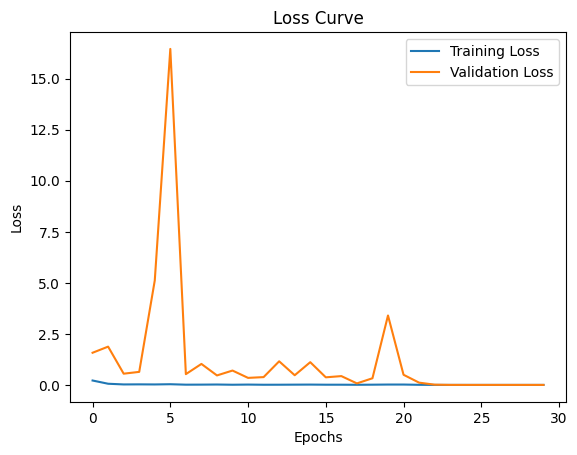

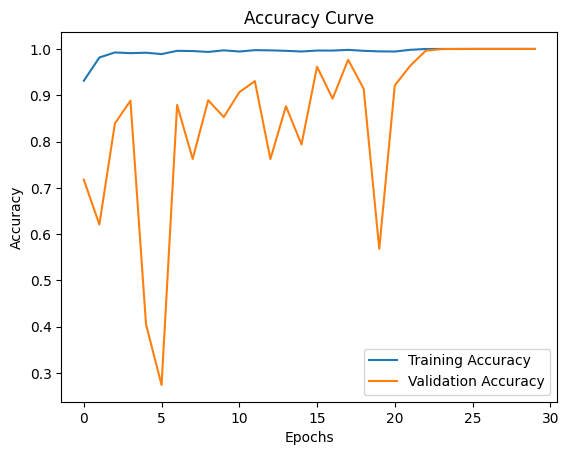

101/101 [==============================] - 17s 163ms/step - loss: 0.0016 - accuracy: 0.9995
ResNet101: Params=42676617, Time=8.388310194015503, Accuracy=0.9980419874191284, Time2=16.63737678527832, Accuracy2=0.9995313882827759


In [7]:
# Create and train ResNet101 256 128
resnet_base = ResNet101(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
resnet_params, resnet_time, resnet_acc, effnet_time2, effnet_acc2 = create_and_train_model(resnet_base, train_gen, test_gen, '/content/drive/MyDrive/Colab Notebooks/resnet101_tomatoAll_256s_128b_30e.model', freeze_layers=False)
print(f"ResNet101: Params={resnet_params}, Time={resnet_time}, Accuracy={resnet_acc}, Time2={effnet_time2}, Accuracy2={effnet_acc2}")

In [8]:
test3_gen = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/tomato_images2/',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)
class_names = test3_gen.class_names

print(test3_gen.class_names)


Found 55 files belonging to 9 classes.
['Tomato Bacterial spot', 'Tomato Early blight', 'Tomato Late blight', 'Tomato Leaf Mold', 'Tomato Septoria leaf spot', 'Tomato Spider mites Two spotted spider mite', 'Tomato Target Spot', 'Tomato Tomato mosaic virus', 'Tomato healthy']


In [9]:
# prompt: load_model from the path

model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_256s_128b_10e.model')
# prompt: load_model from the path

model2 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/resnet101_tomatoAll_256s_128b_30e.model')


1/1 [==============================] - 2s 2s/step
Tomato Bacterial spot: Correct = 2, Incorrect = 3
Tomato Early blight: Correct = 2, Incorrect = 6
Tomato Late blight: Correct = 5, Incorrect = 2
Tomato Leaf Mold: Correct = 0, Incorrect = 10
Tomato Septoria leaf spot: Correct = 0, Incorrect = 0
Tomato Spider mites Two spotted spider mite: Correct = 0, Incorrect = 4
Tomato Target Spot: Correct = 0, Incorrect = 4
Tomato Tomato mosaic virus: Correct = 0, Incorrect = 4
Tomato healthy: Correct = 1, Incorrect = 12


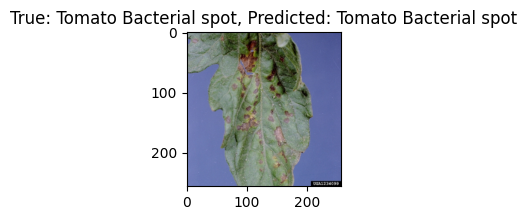

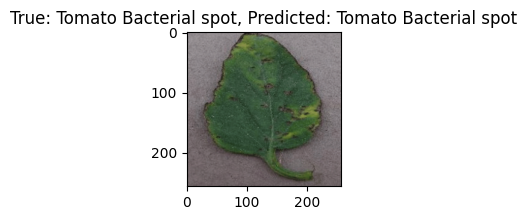

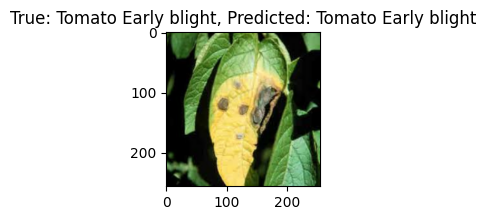

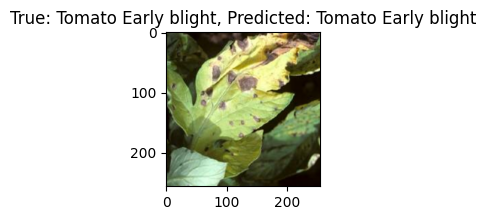

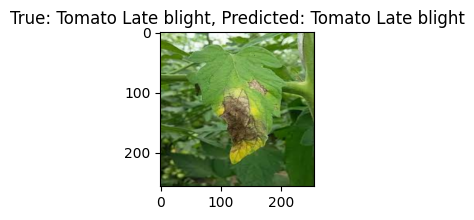

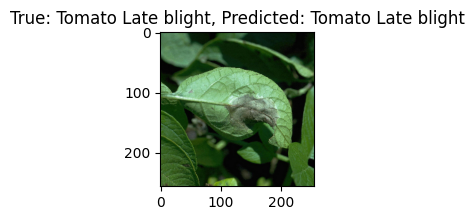

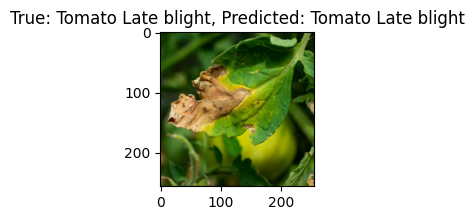

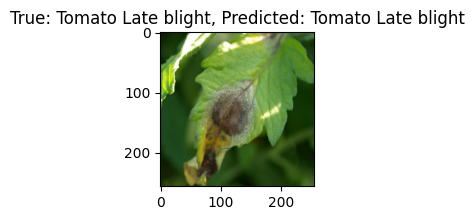

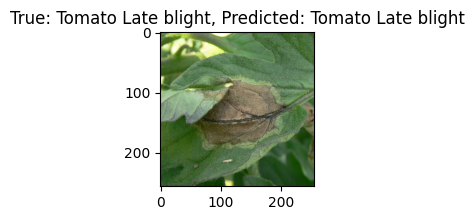

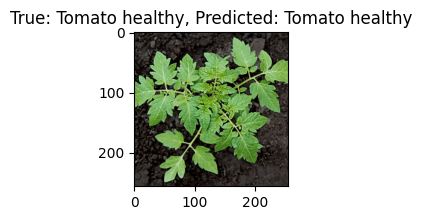

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Collect all test images and their true labels
all_test_images = []
all_true_labels = []
for images, labels in test3_gen:
    all_test_images.extend(images)
    # print(labels)
    all_true_labels.extend(np.argmax(labels, axis=1))

# Convert to numpy arrays for easier manipulation
all_test_images = np.array(all_test_images)
all_true_labels = np.array(all_true_labels)

# Predict labels for the test set
model.evaluate(test3_gen)
predicted = model.predict(test3_gen)
predicted_labels = np.argmax(predicted, axis=1)

# Ensure the arrays are of the same length
min_length = min(len(all_true_labels), len(predicted_labels))
all_true_labels = all_true_labels[:min_length]
predicted_labels = predicted_labels[:min_length]

# print(predicted_labels)

# Find indices of misclassified images
misclassified_indices = np.where(predicted_labels == all_true_labels)[0]


# Initialize counters for correct and incorrect predictions
correct_counts = {class_name: 0 for class_name in class_names}
incorrect_counts = {class_name: 0 for class_name in class_names}

# Iterate over all predictions and update counts
for true_label, predicted_label in zip(all_true_labels, predicted_labels):
    if true_label == predicted_label:
        correct_counts[class_names[true_label]] += 1
    else:
        incorrect_counts[class_names[true_label]] += 1

# Print the counts
for class_name in class_names:
    print(f"{class_name}: Correct = {correct_counts[class_name]}, Incorrect = {incorrect_counts[class_name]}")



# Plot a few misclassified images
num_images_to_show = 1000  # Adjust as needed
for i in misclassified_indices[:num_images_to_show]:
    plt.figure(figsize=(2, 2))
    plt.imshow(all_test_images[i].astype("uint8"))
    true_label_name = class_names[all_true_labels[i]]
    predicted_label_name = class_names[predicted_labels[i]]
    plt.title(f"True: {true_label_name}, Predicted: {predicted_label_name}")
    plt.show()
